In [1]:
import zarr
import numcodecs
from numcodecs import Blosc

results = zarr.open('formatted_results.zarr', mode='r')

In [27]:
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

with open('failed_pdbs.txt') as file:
    pdbs = file.read()

pdbs = pdbs.strip()[2:-2].split( "', '" )

failed_pdbs = []

for pdb in tqdm(pdbs):
    fpath = 'pdbbind_2020/' + pdb + '/' + pdb + '_ligand.mol2'
    orig_mol = Chem.MolFromMol2File(fpath, removeHs=True)
    #mol = Chem.AddHs(orig_mol)
    #AllChem.ConstrainedEmbed(mol, orig_mol)
    #sdf_supplier = Chem.SDMolSupplier(fpath, sanitize=True, removeHs=True)
    #mol = next(sdf_supplier)
    if orig_mol == None:
        failed_pdbs.append(pdb)

print(len(failed_pdbs))
print(failed_pdbs)

100%|██████████| 3807/3807 [00:05<00:00, 649.75it/s]

24
['1a7x', '1h07', '1qpf', '2aoh', '2ci9', '2fou', '2fov', '2foy', '2pll', '3bho', '3bwf', '3cst', '3fxz', '3fy0', '3kck', '3qlb', '3vjs', '3vjt', '3whw', '3zp9', '4i60', '4rlp', '5hlm', '5ujo']


In [2]:
print('\n'.join(results['6esa']['6esa'][0]['complex_results']['pose']['pdb_string_arr']))

HEADER                                            17-JAN-25   XXXX              
EXPDTA    THEORETICAL MODEL                                                     
REMARK 220                                                                      
REMARK 220 EXPERIMENTAL DETAILS                                                 
REMARK 220  EXPERIMENT TYPE                : THEORETICAL MODELLING              
REMARK 220  DATE OF DATA COLLECTION        : 17-JAN-25                          
REMARK 220                                                                      
REMARK 220 REMARK: MODEL GENERATED BY ROSETTA                                   
REMARK 220  VERSION 2024.42+release.3366cf78a3                                  
HETNAM     UNK B 342                                                            
ATOM      1  N   SEP A   1      -6.457  -7.378 -12.065  1.00  0.00           N  
ATOM      2  CA  SEP A   1      -7.903  -7.749 -12.153  1.00  0.00           C  
ATOM      3  C   SEP A   1  

In [3]:
from tqdm import tqdm

test_store = zarr.DirectoryStore('test.zarr')
compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE)

pdbs = []
for pdb in results:
    pdbs.append(pdb)

counter = 0

for pdb in tqdm(pdbs):

    test_root = zarr.group(store=test_store, overwrite=True, path=pdb )
    new_entry = test_root.empty( pdb, shape=1, dtype=object, object_codec=numcodecs.JSON(), compressor=compressor )
    
    new_entry[0] = results[pdb][pdb][0]

    counter += 1
    if counter == 20:
        break

  0%|          | 19/15636 [00:43<9:56:24,  2.29s/it] 


In [4]:
print( list(test_store.keys()) )

['.zgroup', '1a1e/.zgroup', '1a1e/1a1e/0', '1a1e/1a1e/.zarray', '1a08/.zgroup', '1a08/1a08/0', '1a08/1a08/.zarray', '4oya/.zgroup', '4oya/4oya/.zarray', '1a28/.zgroup', '1a28/1a28/0', '1a28/1a28/.zarray', '1a0q/.zgroup', '1a0q/1a0q/0', '1a0q/1a0q/.zarray', '184l/.zgroup', '184l/184l/0', '184l/184l/.zarray', '1a1b/.zgroup', '1a1b/1a1b/0', '1a1b/1a1b/.zarray', '1a09/.zgroup', '1a09/1a09/0', '1a09/1a09/.zarray', '186l/.zgroup', '186l/186l/0', '186l/186l/.zarray', '187l/.zgroup', '187l/187l/0', '187l/187l/.zarray', '16pk/.zgroup', '16pk/16pk/0', '16pk/16pk/.zarray', '1a1c/.zgroup', '1a1c/1a1c/0', '1a1c/1a1c/.zarray', '1a42/.zgroup', '1a42/1a42/0', '1a42/1a42/.zarray', '188l/.zgroup', '188l/188l/0', '188l/188l/.zarray', '1a0t/.zgroup', '1a0t/1a0t/0', '1a0t/1a0t/.zarray', '1a07/.zgroup', '1a07/1a07/0', '1a07/1a07/.zarray', '1a2c/.zgroup', '1a2c/1a2c/0', '1a2c/1a2c/.zarray', '1a30/.zgroup', '1a30/1a30/0', '1a30/1a30/.zarray', '10gs/.zgroup', '10gs/10gs/0', '10gs/10gs/.zarray', '13gs/.zgroup',

In [17]:
pdb = '184l'
test_results = zarr.open( 'test.zarr', mode='a' )
test_results[ pdb ][ pdb ][ 0 ].keys()

dict_keys(['atmname_to_idx', 'complex_results', 'docking_results', 'sanitized_sdf'])

In [18]:
test_results[ pdb ][ pdb ][ 0 ]['docking_results'].keys()

dict_keys(['docking_perturb_pose', 'docking_perturb_pose_relax', 'docking_perturb_pose_relax_ligaway', 'docking_std_pose', 'docking_std_pose_relax', 'docking_std_pose_relax_ligaway'])

In [22]:
test_results[ pdb ][ pdb ][ 0 ]['docking_results'][ 'docking_perturb_pose' ][0].keys()

dict_keys(['idelta_score', 'input_pose_name', 'pdb_string_delta', 'raw_delta_energies', 'raw_energies', 'rmsd_to_crystal', 'rmsd_to_input', 'rmsd_to_lowest_idelta', 'rmsd_to_lowest_score', 'total_score'])

In [7]:
len(results[ pdb ][ pdb ][ 0 ][ 'sanitized_sdf' ])

130

In [8]:
for pdb in test_results:
    print(pdb, 
          len(test_results[ pdb ][ pdb ][ 0 ]['complex_results']),
          [ len(test_results[ pdb ][ pdb ][ 0 ]['complex_results'][x]['pdb_string_arr']) for x in test_results[ pdb ][ pdb ][ 0 ]['complex_results'] if test_results[ pdb ][ pdb ][ 0 ]['complex_results'][x] != None ],
          len(test_results[ pdb ][ pdb ][ 0 ]['docking_results']), 
          [ len(test_results[ pdb ][ pdb ][ 0 ]['docking_results'][x]) for x in test_results[ pdb ][ pdb ][ 0 ]['docking_results'] ])

10gs 3 [6669, 6669, 6669] 0 []
13gs 3 [6662, 6662, 6662] 0 []
16pk 3 [6512, 6512, 6512] 0 []
184l 3 [2663, 2663, 2663] 6 [150, 150, 150, 150, 150, 150]
186l 3 [2663, 2663, 2663] 6 [150, 150, 150, 150, 150, 150]
187l 3 [2651, 2651, 2651] 6 [150, 150, 150, 150, 150, 150]
188l 3 [2651, 2651, 2651] 6 [150, 150, 150, 150, 150, 150]
1a07 3 [3526, 3526, 3526] 6 [150, 150, 150, 150, 150, 150]
1a08 3 [1865, 1865, 1865] 6 [150, 150, 150, 150, 150, 150]
1a09 3 [3522, 3522, 3522] 6 [150, 150, 150, 150, 150, 150]
1a0q 3 [6475, 6475, 6475] 0 []
1a0t 2 [18681] 0 []
1a1b 3 [3538, 3538, 3538] 6 [150, 150, 150, 150, 150, 150]
1a1c 3 [3528, 3528, 3528] 6 [150, 150, 150, 150, 150, 150]
1a1e 3 [3517, 3517, 3517] 6 [150, 150, 150, 150, 150, 150]
1a28 3 [4256, 4256, 4256] 6 [150, 150, 150, 150, 150, 150]
1a2c 3 [4817, 4817, 4817] 6 [150, 150, 150, 150, 150, 150]
1a30 3 [3255, 3255, 3255] 6 [150, 150, 150, 150, 150, 150]
1a37 3 [6405, 6405, 6405] 0 []
1a42 3 [4139, 4139, 4139] 6 [150, 150, 150, 150, 150, 150]

TypeError: 'int' object is not subscriptable

In [9]:
test_results[ '4oya' ][ '4oya' ][0]

0

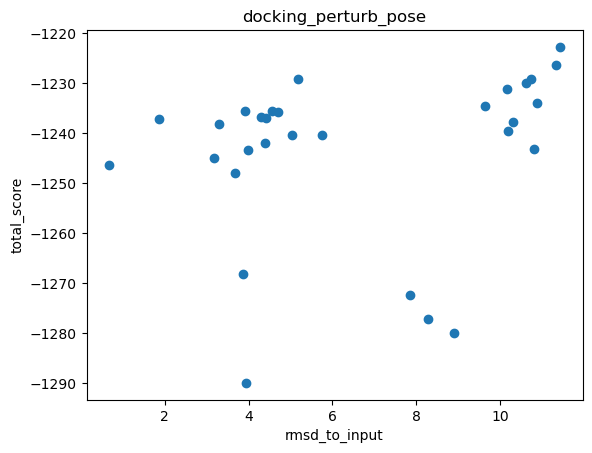

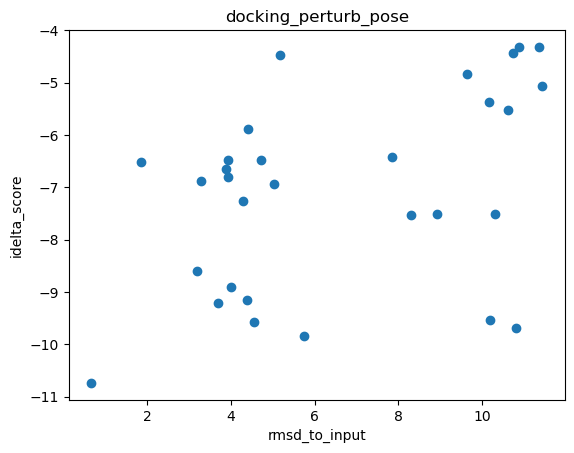

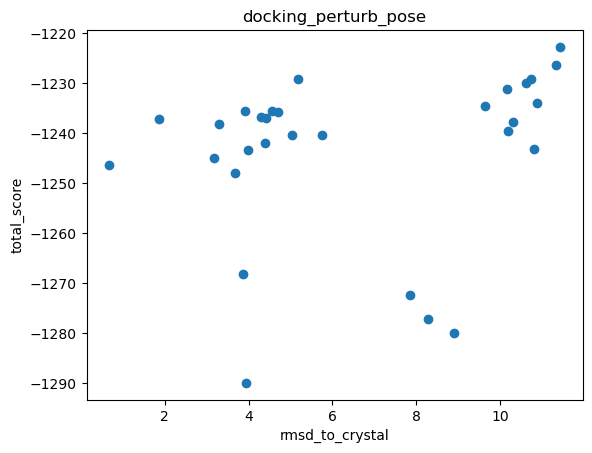

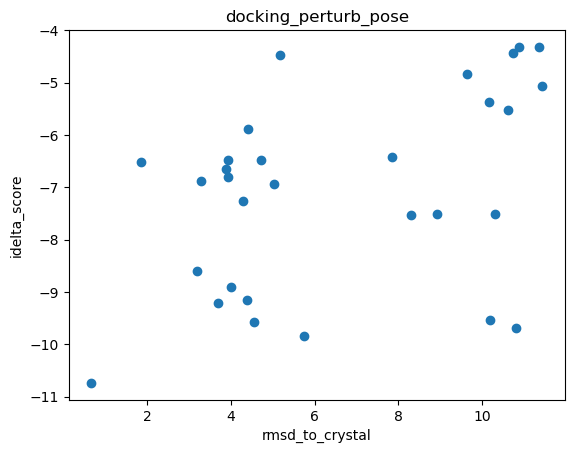

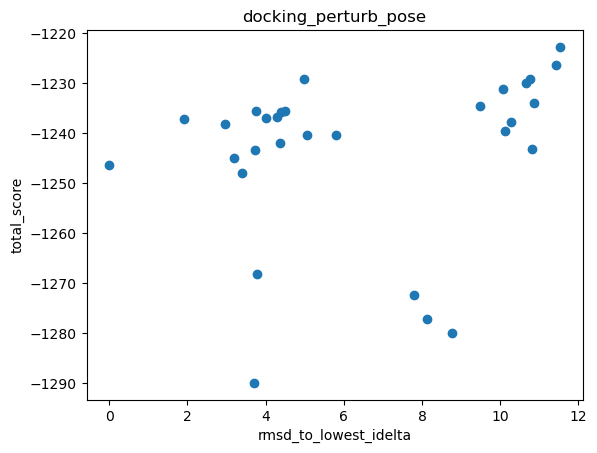

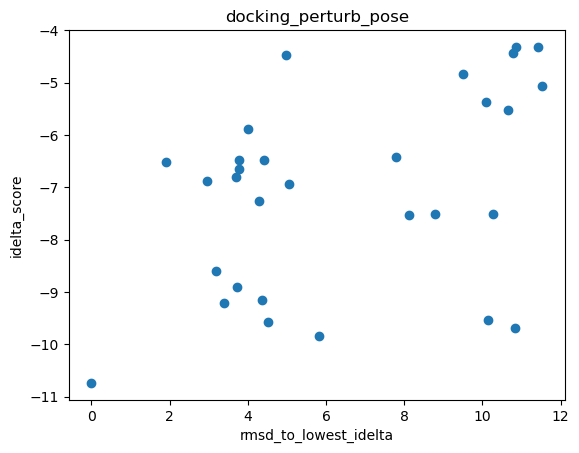

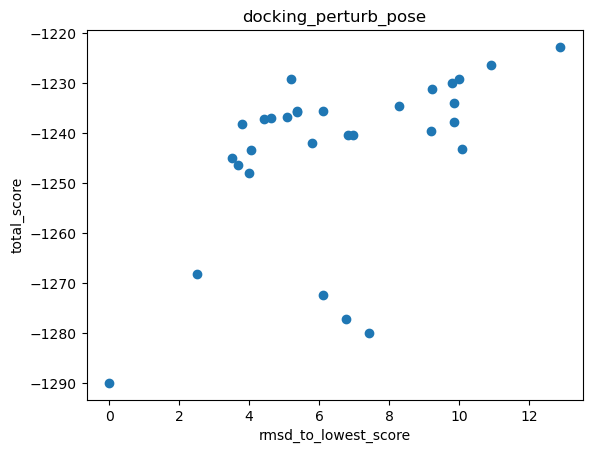

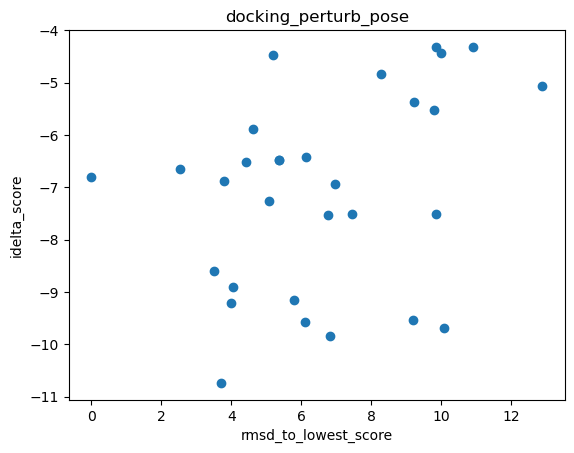

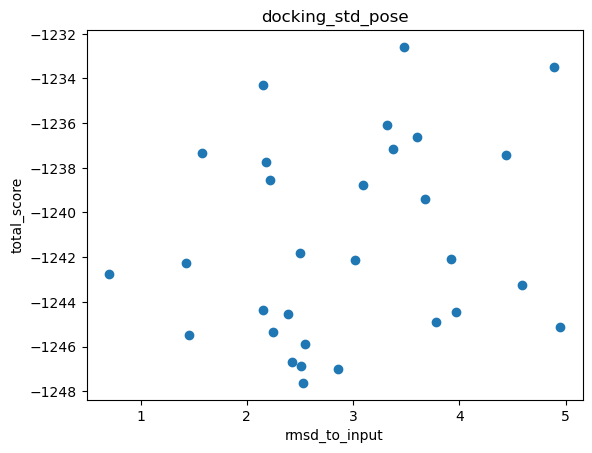

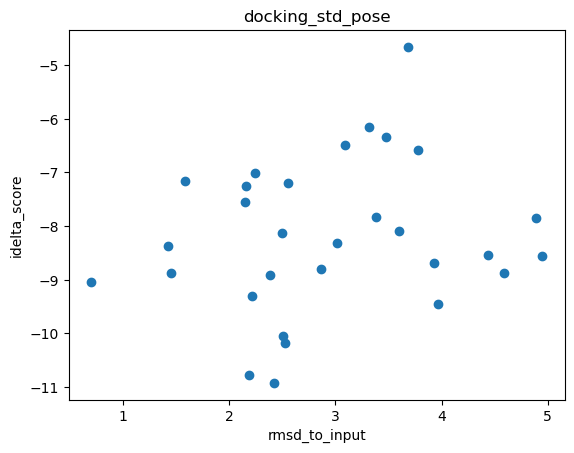

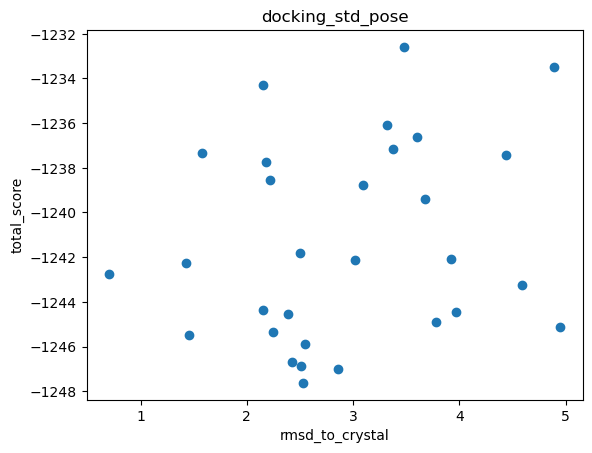

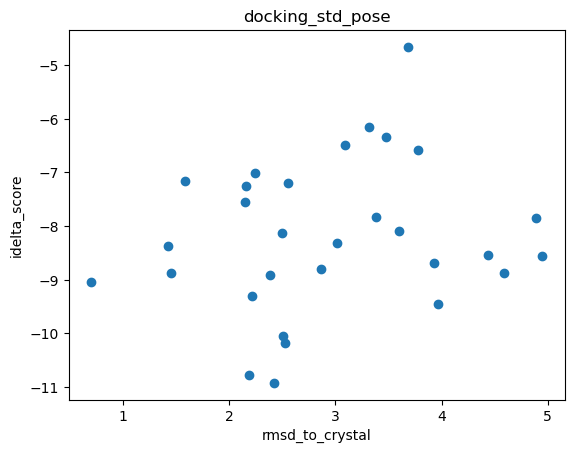

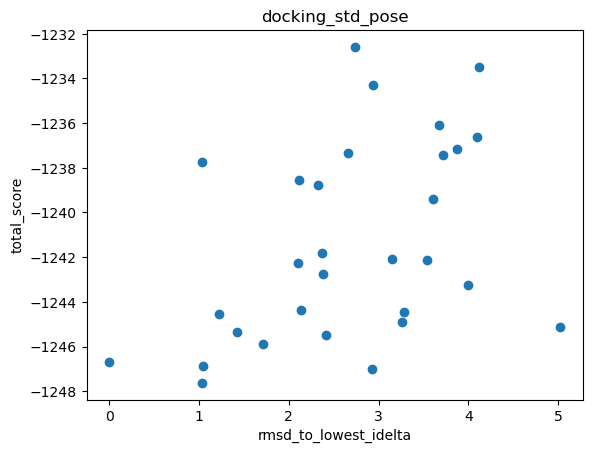

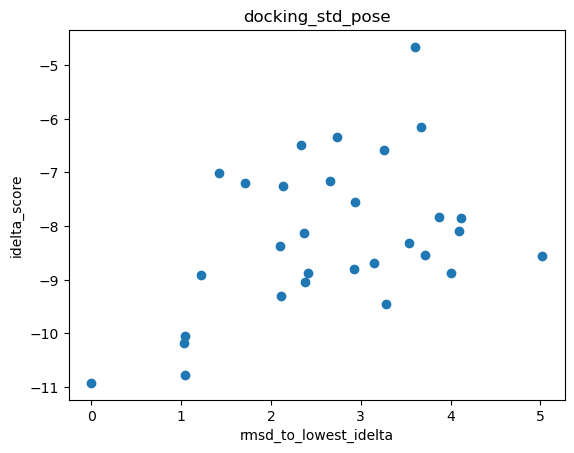

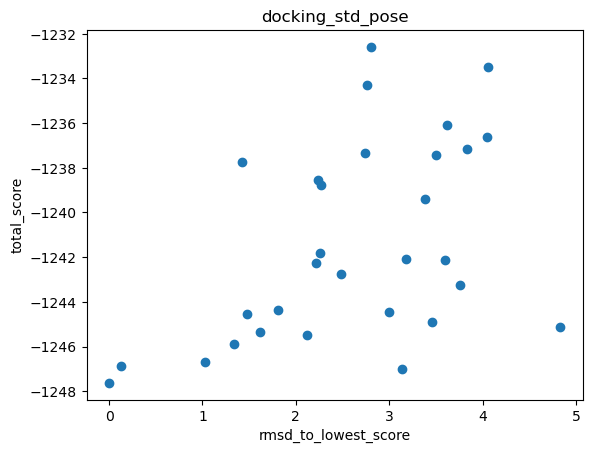

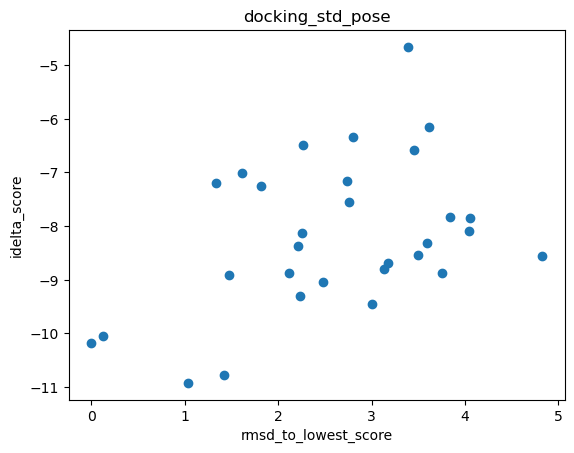

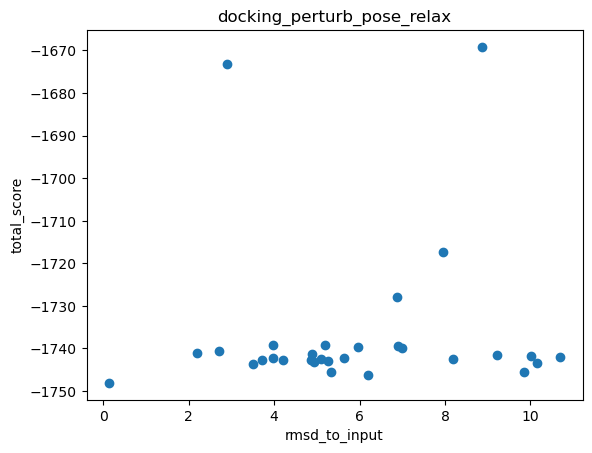

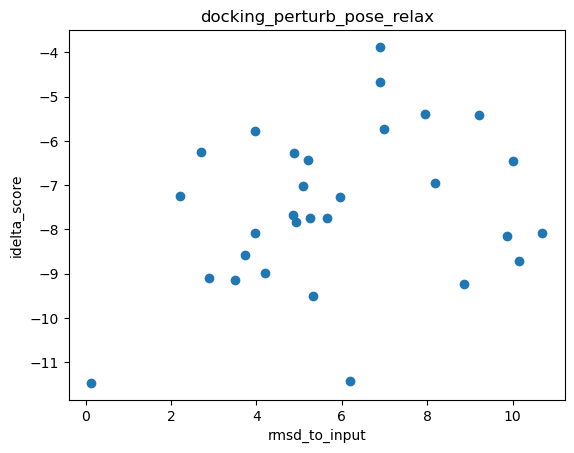

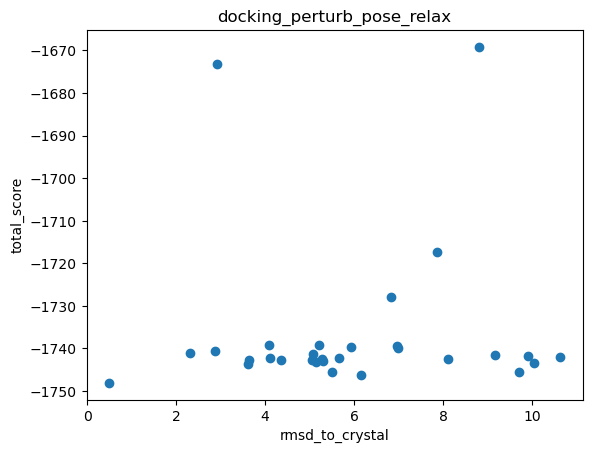

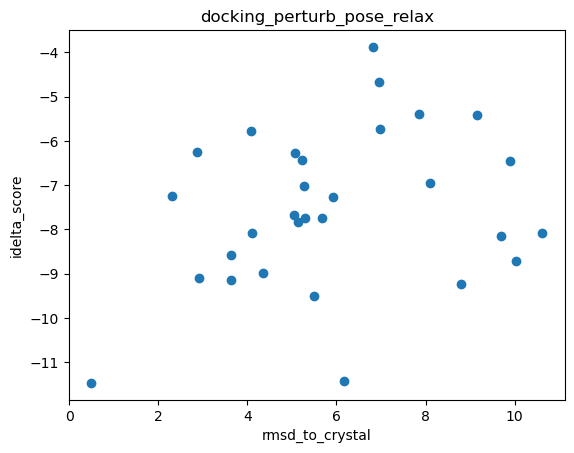

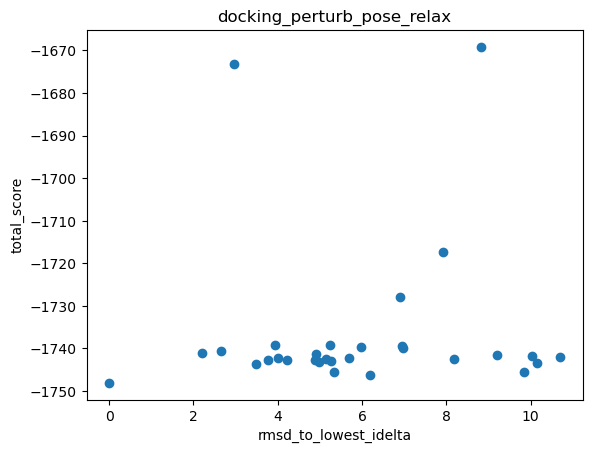

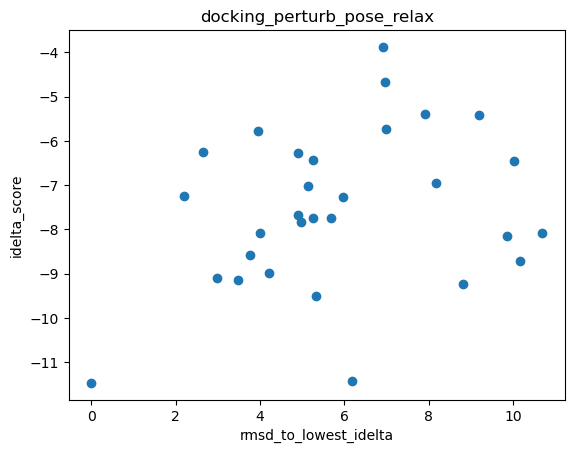

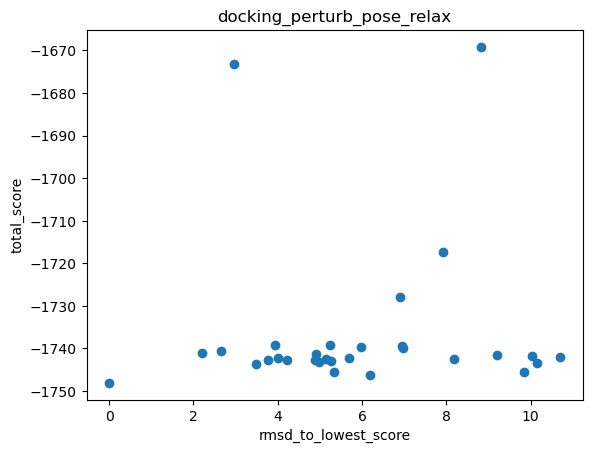

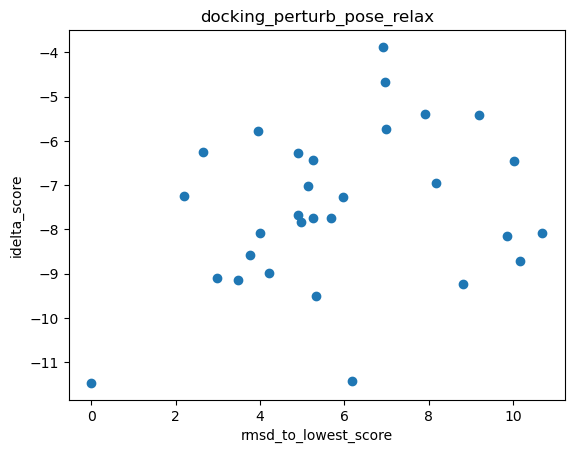

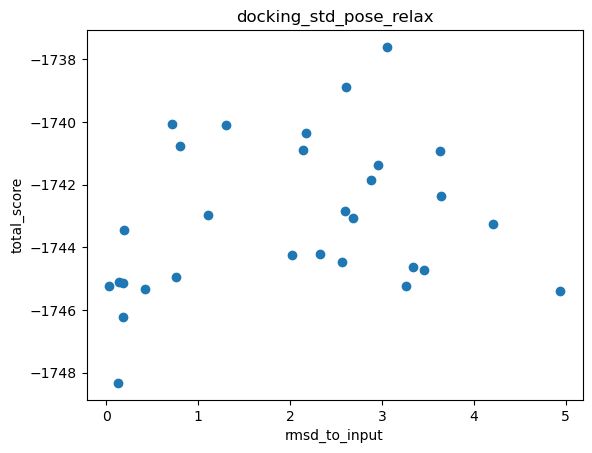

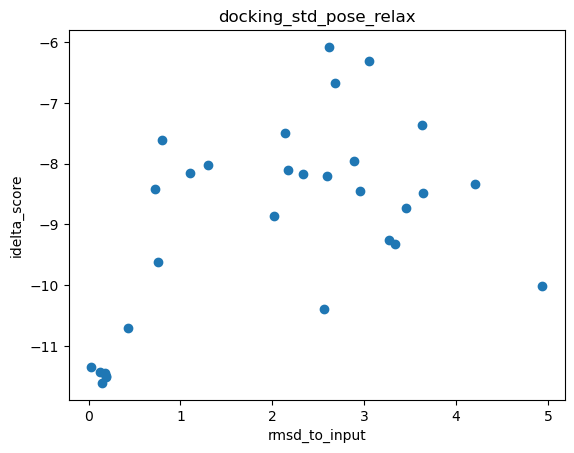

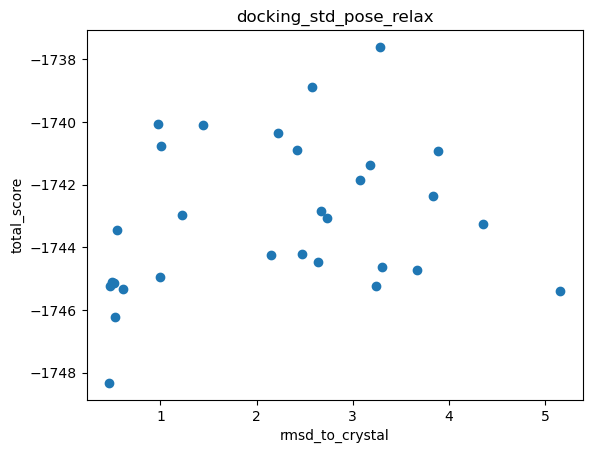

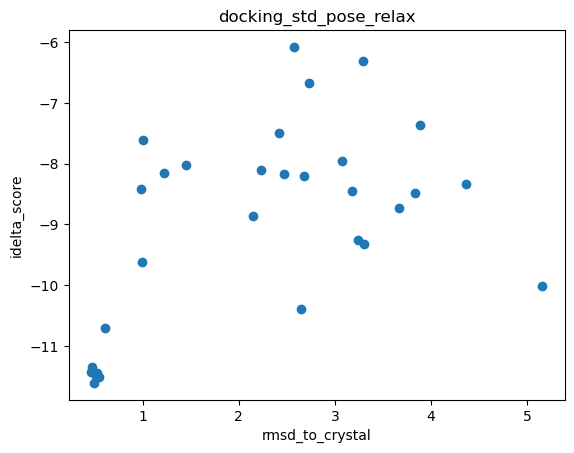

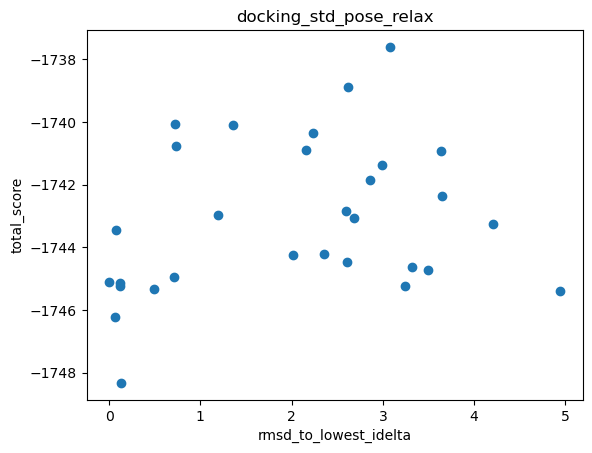

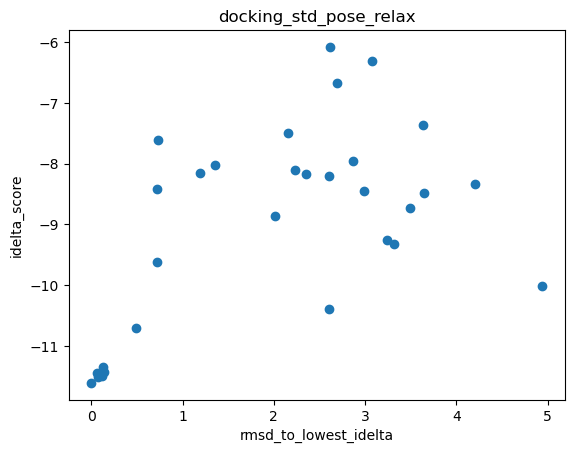

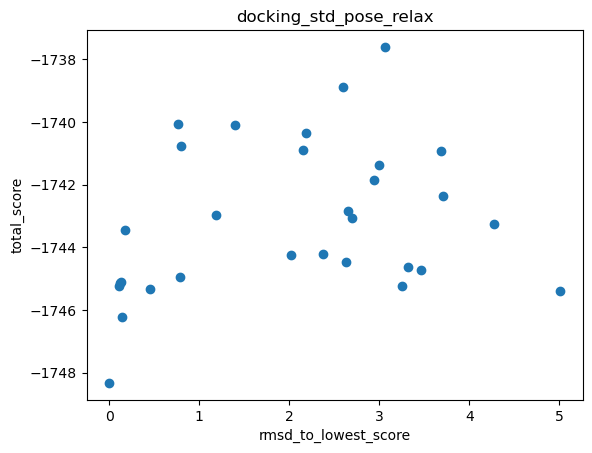

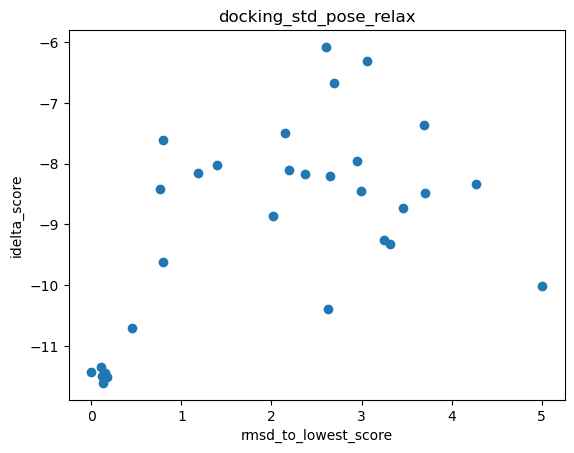

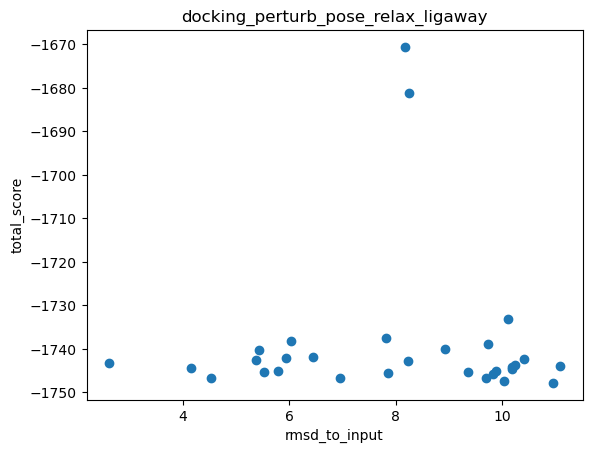

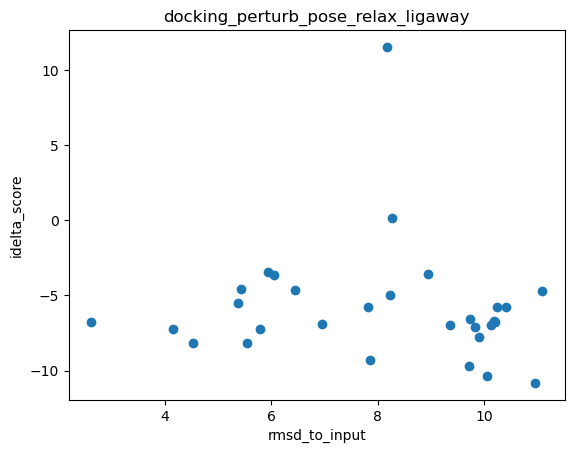

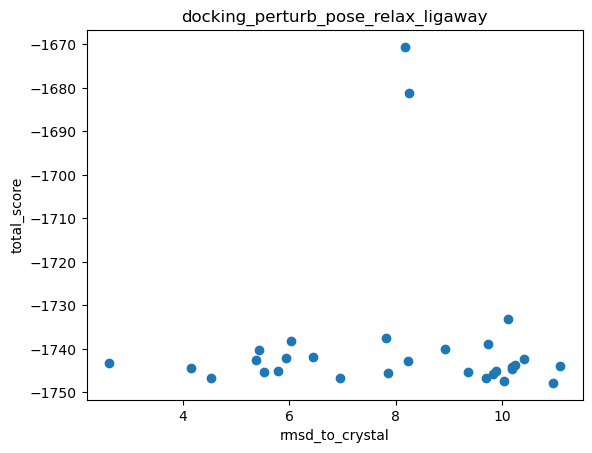

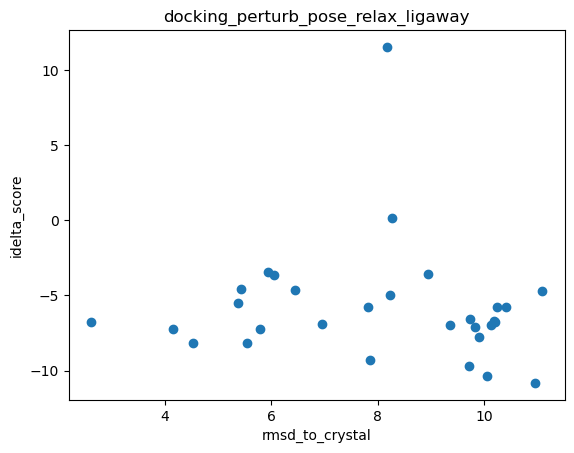

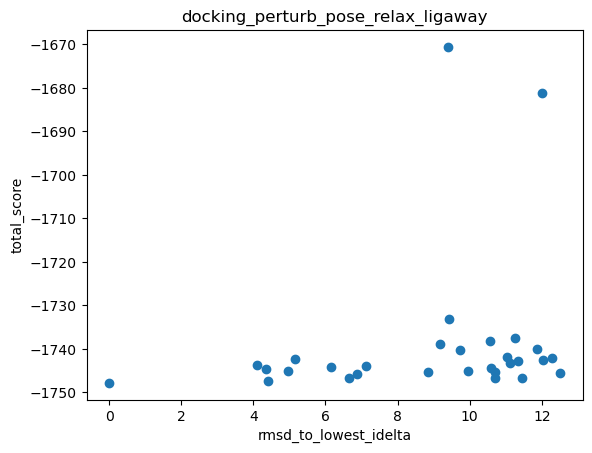

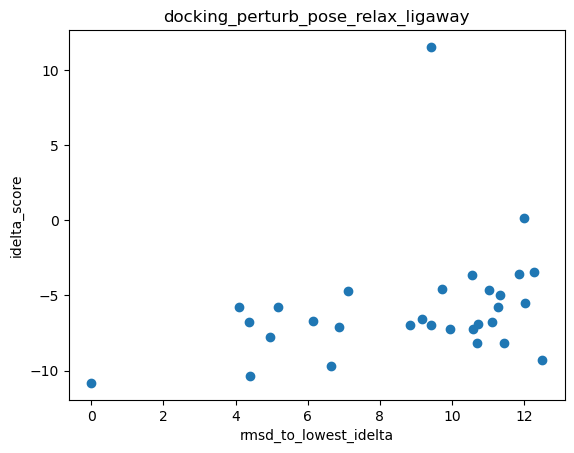

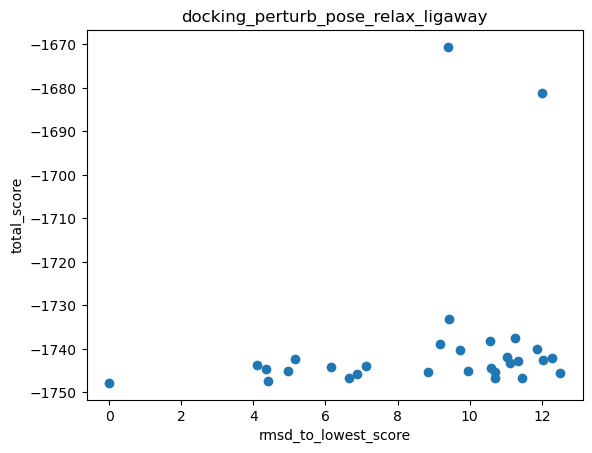

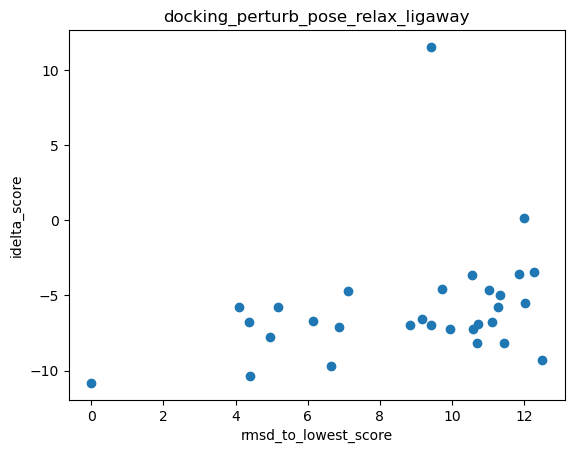

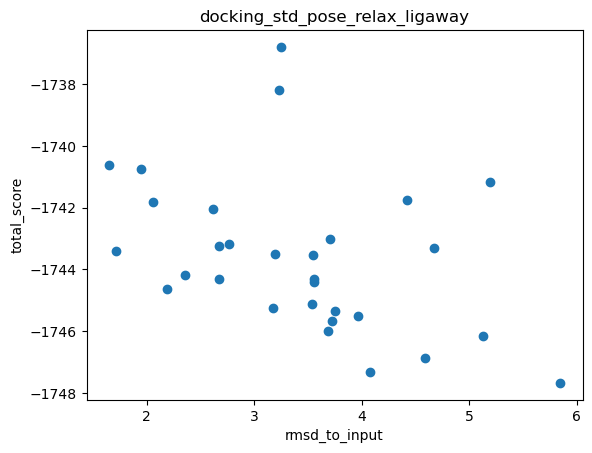

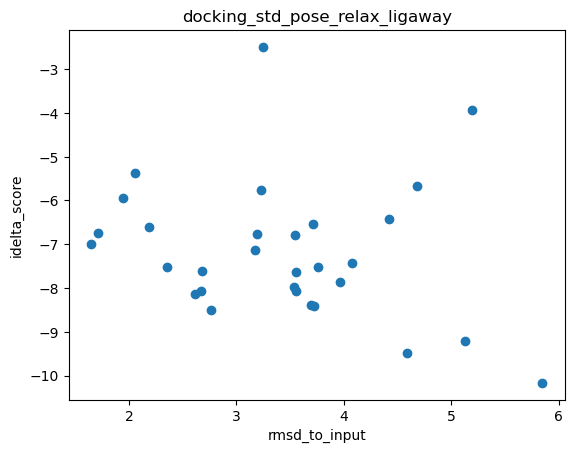

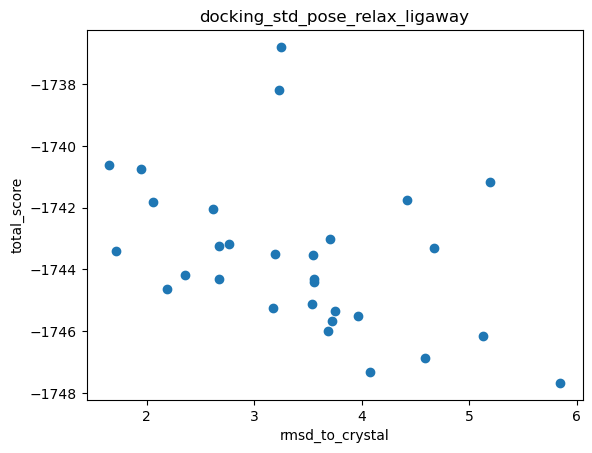

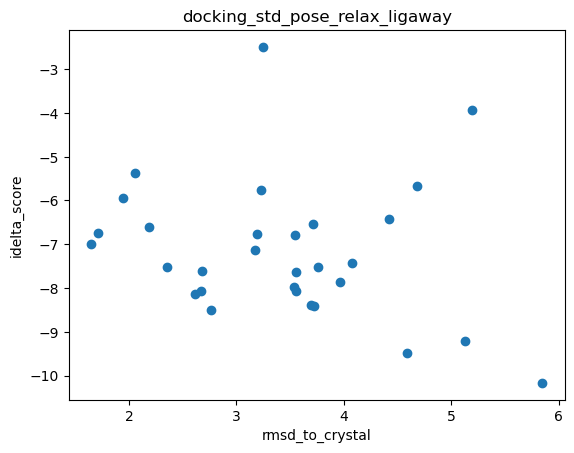

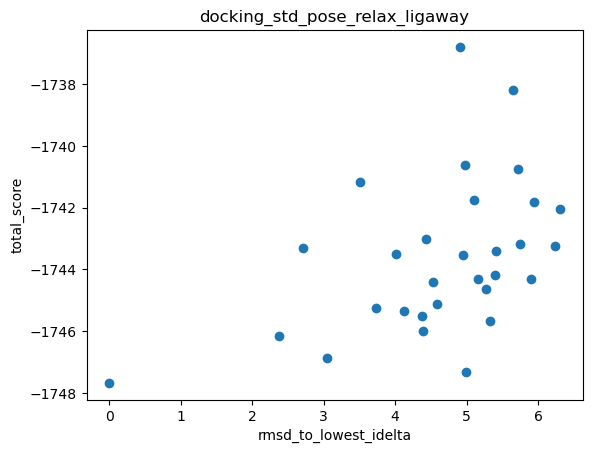

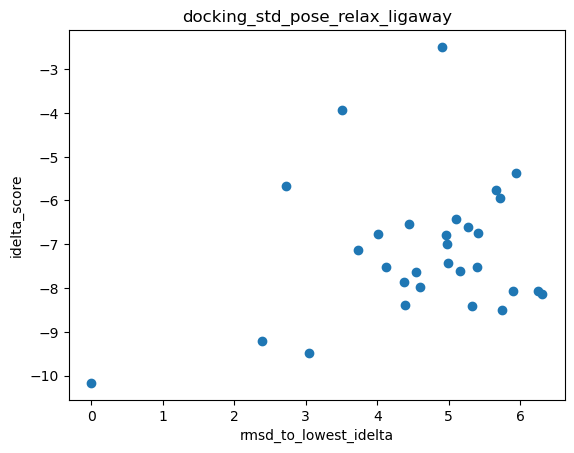

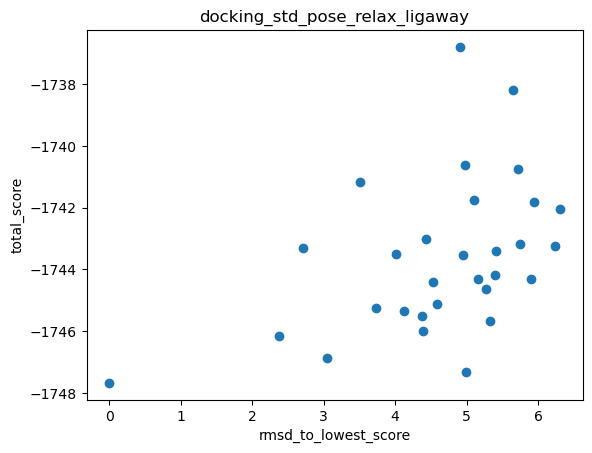

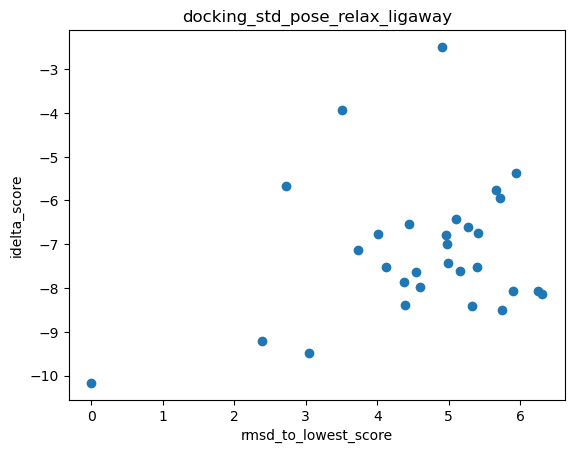

In [76]:
import matplotlib.pyplot as plt

pdb = '13gs'
pose = ['pose', 'pose_relax', 'pose_relax_ligaway']
protocol = ['docking_perturb_', 'docking_std_' ]
rmsd = ['rmsd_to_input', 'rmsd_to_crystal', 'rmsd_to_lowest_idelta', 'rmsd_to_lowest_score']
score = ['total_score', 'idelta_score']

for p in pose:
    for pr in protocol:
        for r in rmsd:
            for s in score:

                x = []
                y = []

                for run in test_results[pdb][pdb][0]['docking_results'][pr+p]:
                    x.append( run[r] )
                    y.append( run[s] )

                plt.scatter( x, y )
                plt.title( pr + p )
                plt.ylabel( s )
                plt.xlabel( r )
                plt.show()